In [1]:
include("notebook_preamble.jl");

In [2]:
using SymPy;
include("TransverseIsingModels.jl")
using .TransverseIsingModels
TIM = TransverseIsingModels;

# Computation of jump operators

In [3]:
⊗ₖ(a, b) = kron(b, a);
const σ0 = [1 0; 0 1];
const σx = [0 1; 1 0];
const σy = [0 -im; im 0];
const σz = [1 0; 0 -1];
const σp = [0 1; 0 0];
const σm = [0 0; 1 0];

In [4]:
function siteop(A, i, n)
    i = i > 0 ? 1 + ((i - 1) % n) : throw(ArgumentError("Site index must be positive."))
    ops = repeat([one(A)], n)
    ops[i] = A
    reduce(⊗ₖ, ops)
end;

In [5]:
function symeigen(H)
    symeig = H.eigenvects()
    vals, vecs = eltype(H)[], []
    for (λ, _, vs) in symeig
        for v in vs
            push!(vals, λ)
            push!(vecs, vec(v))
        end
    end
    vals, vecs
end;

In [6]:
function addentry!(dict, key, value; isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            push!(dict[k], value)
            return dict
        end
    end
    dict[key] = [value]
    dict
end;

In [7]:
firstvalue(i, (x, y)) = x
lastvalue(i, (x, y)) = y
function dictby(A; isequal=isequal, keyof=firstvalue, valof=lastvalue)
    i0, x0 = 1, first(A)
    k0, v0 = keyof(i0, x0), valof(i0, x0)
    dict = Dict(k0 => typeof(v0)[])
    dict = Dict()
    for (i, x) in enumerate(A)
        k, v = keyof(i, x), valof(i, x)
        addentry!(dict, k, v, isequal=isequal)
    end
    dict
end;

In [8]:
TIM.sumprojector(A) = sum(a * a' for a in A);

In [9]:
function incentry!(dict, key; isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            dict[k] += 1
            return dict
        end
    end
    dict[key] = 1
    dict
end;

In [10]:
function combinejumps(Js)
    d = Dict()
    for J in Js
        incentry!(d, J)
    end
    [√(one(eltype(J)) * N)*J for (J, N) in d]
end;

In [11]:
function jumps(vals, vecs, As; combine=true, isequal=isequal)
    eigendict = dictby(zip(vals, vecs))
    ωs = dictby(((E2 - E1, (E1, E2)) for E1 in keys(eigendict) for E2 in keys(eigendict)), isequal=isequal)
    Πs = TIM.projectors(eigendict)
    Jωs = dictmap(ΔEs -> filter(x -> !isequal(x, zero(x)), [simplify.(sum(Πs[E1]*A*Πs[E2] for (E1, E2) in ΔEs)) for A in As]), ωs)
    combine ? dictmap(combinejumps, Jωs) : Jωs
end
spindim(v) = Int(log2(length(v)))
dipole_interactions(n) = vcat(map(A -> [siteop(A, i, n) for i in 1:n], [σx, σy, σz])...)
dipolejumps(vals, vecs; kwargs...) = jumps(vals, vecs,
    dipole_interactions(spindim(first(vecs)));
    kwargs...);

In [12]:
@vars s1p=>"σ₁⁺" s1m=>"σ₁⁻" commutative=false
@vars s2p=>"σ₂⁺" s2m=>"σ₂⁻" commutative=false
@vars s1x=>"σ₁ˣ" s2x=>"σ₂ˣ" commutative=false
@vars s1y=>"σ₁ʸ" s2y=>"σ₂ʸ" commutative=false
@vars s1z=>"σ₁ᶻ" s2z=>"σ₂ᶻ" commutative=false
@vars n1 =>"n₁"   n2=>"n₂"  commutative=false
@vars g d real=true;

In [13]:
spinops = [s1p, s1m, s2p, s2m, s1x, s2x, s1y, s2y, s1z, s2z, n1, n2];
_symspinop = cat([n1 s1p; s1m (1 - n1)], [n2 s2p; s2m (1 - n2)], dims=3)
_dummy_spinop = Dict(s => sympy.Dummy(s.name) for s in spinops);
site_collect_ops(siteops) = push!([_dummy_spinop[op] for op in siteops], 1)
_collect_ops = [a * b for a in site_collect_ops([s1p, s1m, n1]) for b in site_collect_ops([s2p, s2m, n2])];

In [14]:
u, v, w = Wild(:u), Wild(:v), Wild(:w);

In [15]:
symspinop(l, r, i) = _symspinop[l+1, r+1, i];
function jumpsimplify(J)
    s = mapreduce(+, CartesianIndices(J)[J .!= 0]) do I
        x = J[I]
        i, j = Tuple(I - CartesianIndex(1, 1))
        x * symspinop(i÷2, j÷2, 1) * symspinop(i%2, j%2, 2)
    end
    s = subs(expand(s), √(g^2 + 1) => d)
    s = s.simplify()
    s = s.xreplace(_dummy_spinop)
    for op in _collect_ops
        s = s.collect(op)
    end
    s.simplify()
end;

In [16]:
=>ₛ(a, b) = _dummy_spinop[a] => b
thesis_latex(J) = sympy.latex(J,
        imaginary_unit = "\\im",
        symbol_names = Dict(
            g   =>  "g",
            d   =>  "d",
            n1  =>ₛ "\\opr{n}_1",
            n2  =>ₛ "\\opr{n}_2",
            s1p =>ₛ "\\pauli_1^+",
            s2p =>ₛ "\\pauli_2^+",
            s1m =>ₛ "\\pauli_1^-",
            s2m =>ₛ "\\pauli_2^-",
        ));

In [17]:
function save_jump_latex(path, sJωs)
    open(path, "w") do file
        for (ω, Js) in sJωs
            sω = factor(subs(expand(ω), √(g^2 + 1) => d))
            println(file, thesis_latex(sω))
            println(file, " \\\\")
            for J in Js
                println(file, thesis_latex(J))
                println(file, " \\\\")
            end
            println(file, " \\\\")
        end
    end
end;

## Nondegenerate jump operators

In [18]:
H = -2*(σx ⊗ₖ σx) - g*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz)

4×4 Matrix{Sym}:
 -2⋅g   0   0   -2
    0   0  -2    0
    0  -2   0    0
   -2   0   0  2⋅g

In [19]:
sJωs = dictmap(Js -> jumpsimplify.(Js), dipolejumps(symeigen(H)...; combine=true))
save_jump_latex("nondegen-jumps.tex", sJωs)

## Degenerate jump operators

In [20]:
H0 = subs.(-2*(σx ⊗ₖ σx) - g*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz), g => 0)

4×4 Matrix{Sym}:
  0   0   0  -2
  0   0  -2   0
  0  -2   0   0
 -2   0   0   0

In [21]:
sJωs0 = dictmap(Js -> jumpsimplify.(Js), dipolejumps(symeigen(H0)...; combine=true))
save_jump_latex("degen-jumps.tex", sJωs0)

# Dissipator eigenvalue plots

In [22]:
leftmul(A)  = one(A) ⊗ₖ A
rightmul(A) = permutedims(A) ⊗ₖ one(A)
comm(A, B) = A*B - B*A
acomm(A, B) = A*B + B*A
commwith(A) = leftmul(A) - rightmul(A)
acommwith(A) = leftmul(A) + rightmul(A);

In [23]:
nB(ω, β) = 1 / (exp(β*ω) - 1)
γdiv(ω; β) = isapprox(ω, 0, atol=1e-9) ? 0 : ω^3 * (nB(ω, β) + 1)
# γdiv(ω; β) = isapprox(ω, 0, atol=1e-9) ? 0 : ω^2 # High temperature approx.
ℋLSterm(J, S) = S * commwith(J' * J)
ℋLS(Jωs, S; params...) = -im * sum(ℋLSterm(J, S(ω; params...)) for (ω, Js) in Jωs for J in Js)
𝒟term(J, γ) = γ * (leftmul(J) * rightmul(J') - acommwith(J' * J) / 2)
𝒟(Jωs, γ; params...) = sum(𝒟term(J, γ(ω; params...)) for (ω, Js) in Jωs for J in Js);
𝒟LRterm(J, γ) = γ * (leftmul(J) * rightmul(J'))
𝒟LR(Jωs, γ; params...) = sum(𝒟LRterm(J, γ(ω; params...)) for (ω, Js) in Jωs for J in Js);
𝒟Aterm(J, γ) = γ * (- acommwith(J' * J) / 2)
𝒟A(Jωs, γ; params...) = sum(𝒟Aterm(J, γ(ω; params...)) for (ω, Js) in Jωs for J in Js);

In [24]:
function numeigen(H)
    vals, vecs = eigen(H)
    vals, eachcol(vecs)
end

isequalto(atol=1e-9) = (x, y) -> isapprox(x, y, atol=atol)

function unitary_rates(H, dict, γ; params...)
    Jωs = dipolejumps(numeigen(N.(subs.(H, dict)))...;
        combine=true, isequal=isequalto())
    lambham = (x -> isequalto()(x, zero(x)) ? zero(x) : x).(ℋLS(Jωs, γ; params...))
    eigvals(lambham)
end

function dissipation_rates(H, dict, γ; params...)
    Jωs = dipolejumps(numeigen(N.(subs.(H, dict)))...;
        combine=true, isequal=isequalto())
    dissipator = (x -> isequalto()(x, zero(x)) ? zero(x) : x).(𝒟(Jωs, γ; params...))
    eigvals(dissipator)
end;

function dissipation_rates(H, γ; params...)
    Jωs = dipolejumps(numeigen(H)...; combine=true, isequal=isequalto())
    dissipator = (x -> isequalto()(x, zero(x)) ? zero(x) : x).(𝒟(Jωs, γ; params...))
    eigvals(dissipator)
end;

In [25]:
rubric = RGB(0.7, 0.05, 0.0);

In [26]:
function ηenergyvariance(H, η)
    Es = eigvals(H) / η
    Z = sum(exp(-E) for E in Es)
    Ps = [exp(-E) / Z for E in Es]
    H1 = sum(E * P for (E, P) in zip(Es, Ps))
    H2 = sum(E^2 * P for (E, P) in zip(Es, Ps))
    H2 - H1^2
end;

We map $E \mapsto E / \eta$ so that $\eta$ is a dimensionless inverse temperature $\beta$.

In [27]:
using Roots

In [28]:
trnorm(A) = √(tr(A'*A))
trnormalize(A) = A / trnorm(A)
∠(A, B) = acos(trnorm(trnormalize(A)' * trnormalize(B)))
function slerp(A, B, g)
    θ = ∠(A, B)
    (sin((1-g)*θ)*A + sin(g*θ)*B) / sin(θ)
end

# Requirement: `normslerp` must not change the reference Hamiltonian.
function normslerp(A, B, g)
    C = slerp(A, B, g)
    C /= trnorm(C)
end

Ainvar(g, H0) = find_zero(A -> ηenergyvariance(H0(0), 1) - ηenergyvariance(H0(g), 1/A), 1)
function Hinterp(H1, H2)
    H0(g) = normslerp(trnormalize(H1), trnormalize(H2), g)
    g -> Ainvar(g, H0) * H0(g)
end

function plot_interp_rates(H1, H2, g0s; kwargs...)
    β = 1.0
    H = Hinterp(H1, H2)
    rates_ising = [real(dissipation_rates(H(g), γdiv, β = β)) for g in g0s]
    rates_free_ising = real(dissipation_rates(H(0), γdiv, β = β));
    rates_free_trans = real(dissipation_rates(H(1), γdiv, β = β));

    plot(g0s, -hcat(rates_ising...)',
        xlabel=L"Relative angle $g$",
        ylabel="Relative dissipator eigenvalues (negated)",
        color=:black,
        alpha=0.25,
        key=false;
        kwargs...)

    scatter!(repeat([g0s[1] - 2e-2], length(rates_free_ising)), -rates_free_ising,
        marker=(:rtriangle, 2, rubric),
        markerstrokecolor=rubric
    )
    scatter!(repeat([g0s[end] + 2e-2], length(rates_free_trans)), -rates_free_trans,
        marker=(:ltriangle, 2, rubric),
        markerstrokecolor=rubric
    )
end;

In [29]:
η0s = 10 .^ range(-1, 1.5, length=128)
βs = [1e-1, 2e-1, 5e-1, 1e0, 2e0, 5e0, 1e1, 2e1, 5e1];

The Ising interaction and transverse-field Hamiltonians are

In [30]:
Hx(n) = -sum(siteop(σx, i, n) * siteop(σx, i+1, n) for i in 1:n)
Hz(n) = -sum(siteop(σz, i, n) for i in 1:n);

Convenient slerp:

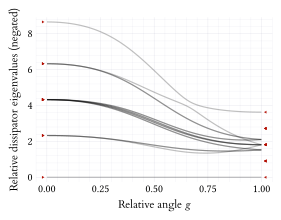

In [31]:
plot_interp_rates(Hx(2), Hz(2), range(1e-3, 1-1e-3, length=64))

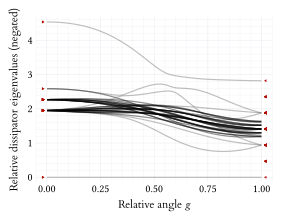

In [32]:
plot_interp_rates(Hx(3), Hz(3), range(1e-3, 1-1e-3, length=64))

In [33]:
Hp = Hinterp(Hx(6), Hz(6));

In [34]:
lgs = range(1e-3, 1-1e-3, length=64)
energies = [eigvals(Hp(g)) for g in lgs]
Hnorms = [trnorm(Hp(g))^2 for g in lgs]
energydifferences = [[x - y for (x, y) in Iterators.product(Es, Es)] for Es in energies];

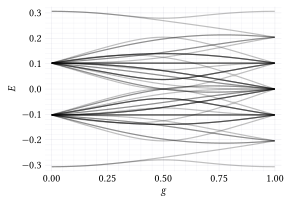

In [35]:
plot(lgs, hcat(energies...)', color=:black, alpha=0.25, key=false, xlabel=L"g", ylabel=L"E")

# Plots for seminar

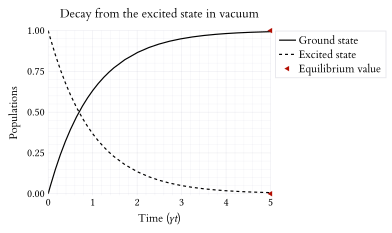

In [36]:
σ2zs(n) = -1 / (2n + 1)
σ2z(τ, n) = (1 - σ2zs(n))*exp(-τ) + σ2zs(n)
nH = 0
plot(τ -> (1 - σ2z(τ, nH))/2, label="Ground state",
    color=:black,
    xlim=(0, 5),
    ylim=(-0.01, 1),
    xlabel=L"Time ($\gamma t$)",
    ylabel="Populations",
    title="Decay from the excited state in vacuum",
)
plot!(τ -> (1 + σ2z(τ, nH))/2, xlim=(0, 5), label="Excited state", linestyle=:dash, color=:black)
scatter!(5 * [1, 1], [1 + σ2zs(nH), 1 - σ2zs(nH)] / 2, label="Equilibrium value",
    marker=(:ltriangle, 4, rubric),
    markerstrokecolor=rubric)

In [37]:
savefig("populations.pdf")

# Explicit simulation

`QuantumOptics` simulation

In [82]:
g = 0.75
n = 4
b = SpinBasis(1//2)
sys = ⊗(repeat([b], n)...)
Hsys = Hinterp(Hx(n), Hz(n))(g)
Jωs = dipolejumps(numeigen(Hsys)...; combine=true, isequal=isequalto())
η = 1e1 # η = τB/τS ~ β.
α = 1e-2 # Modifies amplitudes of γ and S due to vacuum timescale. √α = τ0 / τS.
Ω = 1e1 * maximum(keys(Jωs))
jumpops, rates = [], Float64[]
for (ω, Js) in Jωs
    for J in Js
        push!(rates, α * (1e-1 < η*ω ? ω^3 * (1 + 1 / (exp(η*ω) - 1)) : ω^2 / η))
        push!(jumpops, DenseOperator(sys, J))
    end
end
lambham = -α * (Ω / π) * sum(ω * J' * J for (ω, Js) in Jωs for J in Js);

In [83]:
σzm = dense(embed(sys, 1, sigmaz(b)))
function fout(t, ρ)
    ρ = normalize(ρ)
    real(expect(σzm, ρ))
end
Hspin = DenseOperator(sys, Hsys)
Hopen = DenseOperator(sys, Hsys + lambham)
σzth = fout(0.0, thermalstate(Hspin, 1e0))
tf = 5e2
ts = range(0.0, tf, length=501);

In [84]:
up = spinup(b)
ψ0 = ⊗(repeat([up], n)...)
ρ0 = projector(ψ0)
_, fouts0 = timeevolution.schroedinger(ts, ψ0, Hspin; fout=fout)
_, fouts1 = timeevolution.schroedinger(ts, ψ0, Hopen; fout=fout)
_, fouts = timeevolution.master(ts, ρ0, Hopen, jumpops; rates=rates, fout=fout)
_, foutsd = timeevolution.master(ts, ρ0, 0*Hspin, jumpops; rates=rates, fout=fout);

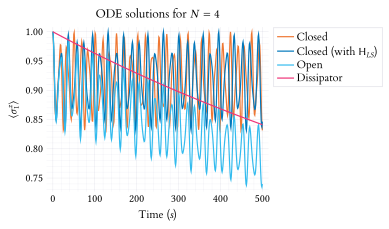

In [85]:
plot(
    title=L"ODE solutions for $N = %$n$",
    xlabel=L"Time ($s$)",
    ylabel=L"\ev{\pauli_1^z}",
)
plot!(ts, [fouts0 fouts1 fouts foutsd], label=["Closed" L"Closed (with $\ham_{LS}$)" "Open" "Dissipator"])

In [86]:
ℒ = steadystate.liouvillian(Hopen, jumpops; rates=rates);

The adjoint Liouvillian can be found by taking the adjoint of the matrix for $\liou$. This has the same spectrum as $\liou$.

In [87]:
ℒspectrum = steadystate.liouvillianspectrum(ℒ; nev=length(ℒ.basis_r[1])*length(ℒ.basis_r[2]))
𝒟rates = real(ℒspectrum[1])

256-element Vector{Float64}:
 -5.838114450896572e-17
 -0.0003652550698261713
 -0.0005576378780888638
 -0.0005897939990281621
 -0.0006862996215950946
 -0.0007595582436676537
 -0.0007826662503731249
 -0.0009919106836237149
 -0.001003894376938983
 -0.0010077102062510219
 -0.001019334425866082
 -0.0010193344258660913
 -0.001019334425866104
  ⋮
 -0.0008543973944413522
 -0.0008543973944414531
 -0.0014685352871178672
 -0.0014685352871172002
 -0.0014685352871170192
 -0.0014685352871167956
 -0.0013677753448480153
 -0.001367775344847003
 -0.0014233243847974158
 -0.0014233243847979965
 -0.0013076713047524141
 -0.0013076713047521782

In [88]:
coeffs = hcat([vec(V.data) for V in ℒspectrum[2]]...) \ vec(ρ0.data);
sort(abs.(coeffs))

256-element Vector{Float64}:
 4.8129403114257614e-18
 1.5449795787448382e-17
 1.727494489019397e-17
 1.7463937062653346e-17
 2.18699878343891e-17
 2.3970752209406946e-17
 2.5889034811833493e-17
 3.3448815127084966e-17
 3.3819052056488173e-17
 3.454848419463606e-17
 3.4682140309840146e-17
 3.9758831726923904e-17
 4.086597661901566e-17
 ⋮
 0.0569386874926088
 0.07989059466014392
 0.101325661372742
 0.10132566137274322
 0.14943346648784195
 0.15590536308967237
 0.17449270893579624
 0.1744927089357989
 0.1822680435023073
 0.19966478186210795
 0.30892897605345554
 0.35351824313420654

In [89]:
eigenexpectations = [tr(σzm * V) for V in ℒspectrum[2]]
contributors = @. (abs(eigenexpectations) > 1e-9) & (abs(coeffs) > 1e-9)
weightedrate = -real(sum(@. abs2(coeffs) * ℒspectrum[1]) ./ sum(abs2, coeffs))

0.0005522307757650771

Note that the eigenoperators are not orthogonal.

In [90]:
sum(abs, [tr(V1' * V2) for V1 in ℒspectrum[2], V2 in ℒspectrum[2]] - Matrix(1.0I, 256, 256))

80.85832378119446

In [91]:
using LsqFit

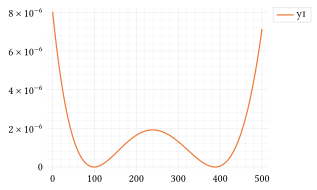

In [92]:
@. decay_exponential(x, p) = p[1]*exp(-x*p[2])
p0 = [1.0, 1e-4]
fit = curve_fit(decay_exponential, ts, foutsd, p0)
plot(ts, (foutsd .- decay_exponential(ts, fit.param)) .^ 2)

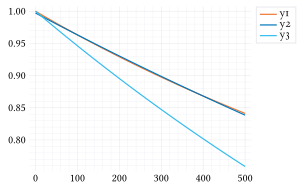

In [93]:
plot(ts, [1.0*foutsd decay_exponential(ts, fit.param) decay_exponential(ts, [1.0, weightedrate])])

In [94]:
fit.param

2-element Vector{Float64}:
 0.9971667716190877
 0.00034645714133736254

# Spaghetti

In [51]:
using KernelDensity

Typical inverse frequency differences are on the order of the system time. Even the higher differences (not shown) are well below the relaxation time.

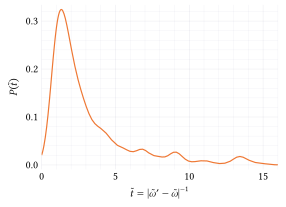

In [52]:
ωkde = kde([1 / abs(ω2 - ω1) for ω1 in keys(Jωs) for ω2 in keys(Jωs) if ω1 ≉ ω2]);
plot(x -> pdf(ωkde, x), xlim=(0, 2^n), key=false, xlabel=L"\tilde{t} = \abs{\tilde{\omega}' - \tilde{\omega}}^{-1}", ylabel=L"P(\tilde{t})")

In [53]:
using ThreadsX

In [95]:
α = 1e-2 # Modifies amplitudes of γ and S due to vacuum timescale. α = τ0 / τB τS.
Ω0 = 1e1
g = 0.25
n = 2
b = SpinBasis(1//2)
sys = ⊗(repeat([b], n)...)
up = spinup(b)
ψ0 = ⊗(repeat([up], n)...)
ρ0 = projector(ψ0)
σzm = dense(embed(sys, 1, sigmaz(b)))
Hint = Hinterp(Hx(n), Hz(n));

In [96]:
function 𝒟_rates(H, n = Int(log2(size(H)[1])); η=1.0, ρ0, op)
    Jωs = dipolejumps(numeigen(H)...; combine=true, isequal=isequalto())
    sys = ρ0.basis_r
    jumpops, rates = [], Float64[]
    for (ω, Js) in Jωs
        for J in Js
            push!(rates, 1e-1 < η*ω ? ω^3 * (1 + 1 / (exp(η*ω) - 1)) : ω^2 / η)
            push!(jumpops, DenseOperator(sys, J))
        end
    end
    # No Hamiltonian needed if we are only interested in the dissipator.
    𝒟 = steadystate.liouvillian(DenseOperator(sys), jumpops; rates=rates);
    𝒟rates, 𝒟ops = steadystate.liouvillianspectrum(𝒟; nev=4^n)
    c = hcat([vec(V.data) for V in 𝒟ops]...) \ vec(ρ0.data)
    eigenexpectations = [tr(op * V) for V in 𝒟ops]
    weightedrate = real(sum(abs2.(c) .* 𝒟rates) ./ sum(abs2, c))
    sort(real(𝒟rates)), weightedrate
end;

In [97]:
function plot_𝒟_rates(Hint, g0s; η=1.0, ρ0, op, kwargs...)
    outs = ThreadsX.map(g -> 𝒟_rates(Hint(g); η, ρ0, op), g0s)
    rates = [o[1] for o in outs]
    r0 = [o[2] for o in outs]
    rates0 = 𝒟_rates(Hint(0); η, ρ0, op)[1]
    rates1 = 𝒟_rates(Hint(1); η, ρ0, op)[1]

    plot(g0s, -hcat(rates...)',
        xlabel=L"Relative angle $g$",
        ylabel="Relative dissipator eigenvalues (negated)",
        color=:black,
        alpha=0.25,
        key=false;
        kwargs...)

    scatter!(repeat([g0s[1] - 2e-2], length(rates0)), -rates0,
        marker=(:rtriangle, 2, rubric),
        markerstrokecolor=rubric
    )
    scatter!(repeat([g0s[end] + 2e-2], length(rates1)), -rates1,
        marker=(:ltriangle, 2, rubric),
        markerstrokecolor=rubric
    )
    plot!(g0s, -r0, color=rubric)
end;

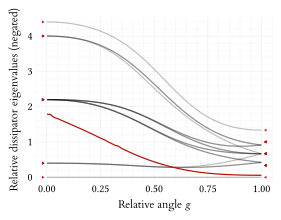

In [98]:
plot_𝒟_rates(Hint, range(1e-3, 1-1e-3, length=64); η=1e1, ρ0, op=σzm)

In [122]:
resolution = 64
g0s = range(1e-3, 1-1e-3, length=resolution)
ηs = range(0, 1, length=resolution)
gridrates = ThreadsX.map(p -> 𝒟_rates(Hint(p[1]); η=10^(p[2]), ρ0, op=σzm), Iterators.product(g0s, ηs));

In [123]:
ratetensor = Array{Float64}(undef, (resolution, resolution, 4^n))
for i in eachindex(g0s), j in eachindex(ηs)
    ratetensor[i, j, :] = gridrates[i, j][1]
end
oprates = [x[2] for x in gridrates];

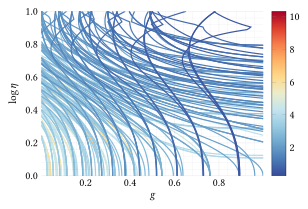

In [124]:
# Disregard noisy zero rate.
plot(g0s, ηs, collect(eachslice(-ratetensor[:, :, 1:end-1], dims=3)),
    st=:contour,
    xlabel=L"g",
    ylabel=L"\log\eta",
    zlabel="Decay rate",
)

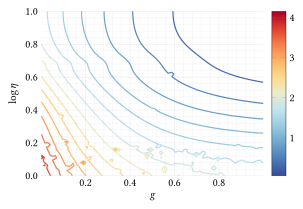

In [125]:
plot(g0s, ηs, -oprates,
    st=:contour,
    xlabel=L"g",
    ylabel=L"\log\eta",
    zlabel="Decay rate",
)